In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/hotel-booking-demand/hotel_bookings.csv


## Hotel Bookings - Feature engineering and Classification

### Importing the modules

In [2]:
from math import *
import pandas as pd
import numpy as np

# import plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
#from pandas.plotting import scatter_matrix
%matplotlib inline
plt.style.use(['fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 2
import seaborn as sns

# import the ML algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# pre-processing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.data import QuantileTransformer

# import libraries for model validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# import libraries for metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)


### Reading the Dataset and looking at the statistics

In [3]:
bookings = pd.read_csv("/kaggle/input/hotel-booking-demand/hotel_bookings.csv")
bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# Dataset information
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [5]:
#Statistics of the data
bookings.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


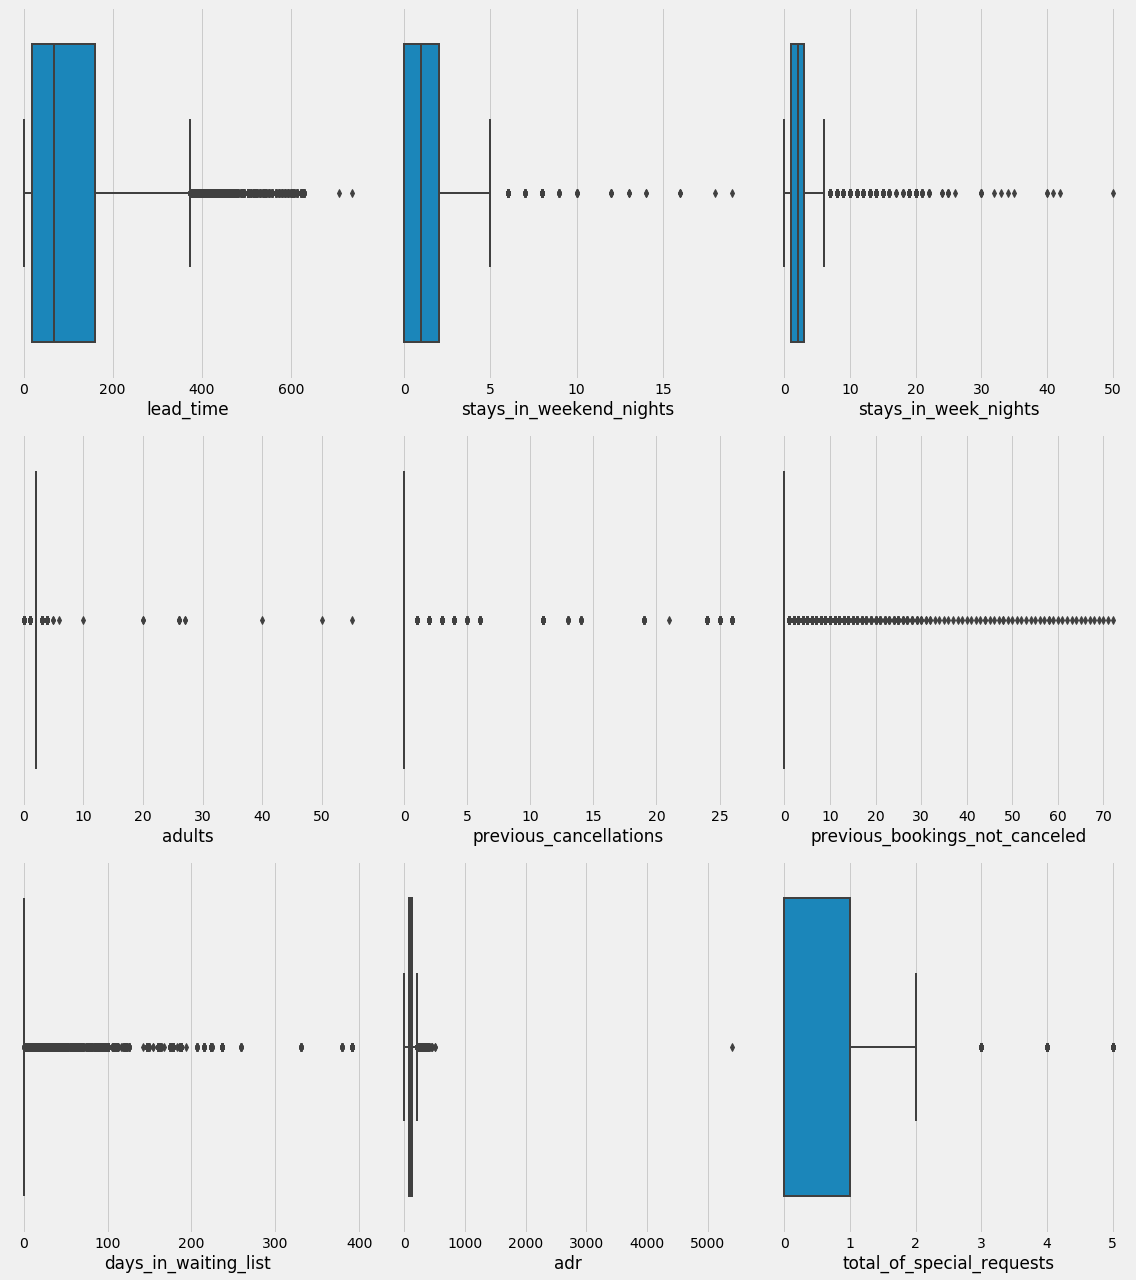

In [6]:
# Creating a boxplot for Outlier detection
features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'previous_cancellations', 'previous_bookings_not_canceled',
            'days_in_waiting_list', 'adr', 'total_of_special_requests']
n = 1
plt.figure(figsize=(16,18))
for feature in features:
    plt.subplot(3,3,n)
    sns.boxplot(bookings[feature])
    n+=1
    plt.tight_layout()

### Statistics shows that there are many Outliers. They will be treated eventually.

In [7]:
# Check for the missing data
bookings.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [8]:
# Some data are missing large in number, and can be conveniently dropped along with unnecessary features
bookings.drop(['agent', 'company', 'arrival_date_week_number'], axis=1, inplace=True)

In [9]:
# Lets look into the numbers of children accompanying the adults since there are few missing values in children column
bookings.children.value_counts()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

In [10]:
# Majority of the visitors were not accompanied by children and hence missing data can be replaced by number of children = 0
bookings.children.fillna(value=0.0, inplace=True)

In [11]:
# Iterating the country column by running CountryCoverter revealded that, most of the clients were from Europe. 
# Therefore all missing values are replaced with the country of maximum occurance, Portugal 
bookings.country.fillna(value='PRT', inplace=True)

### You may avoid this step , its gonna be hard time for your cpu!

In [12]:
pip install country_converter

     |████████████████████████████████| 45 kB 1.1 MB/s 
  Created wheel for country-converter: filename=country_converter-0.6.7-py3-none-any.whl size=50215 sha256=128a2c98a2a53317096022de84945702c85ad768a84f5269e3bf46a33c6ddc31
  Stored in directory: /root/.cache/pip/wheels/c3/14/c5/643f9ed1d6335a90d70009ea68691f6bf65a3ad6b9e5d2aa3f
Successfully built country-converter
Note: you may need to restart the kernel to use updated packages.


In [13]:
#Lets now convert all the countries to their respective continents to see the continent-wise statistics
import country_converter as coco
cc = coco.CountryConverter()
continents = []
for index, row in bookings.iterrows():
    continent = cc.convert([row.country], to='continent')
    continents.append(continent)
cont_df = pd.DataFrame(continents, columns=['continent'])
bookings = pd.concat([bookings, cont_df], 1)

In [14]:
bookings.continent.value_counts()

Europe        108314
America         4982
Asia            4468
Africa          1114
Oceania          507
not found          3
Antarctica         2
Name: continent, dtype: int64

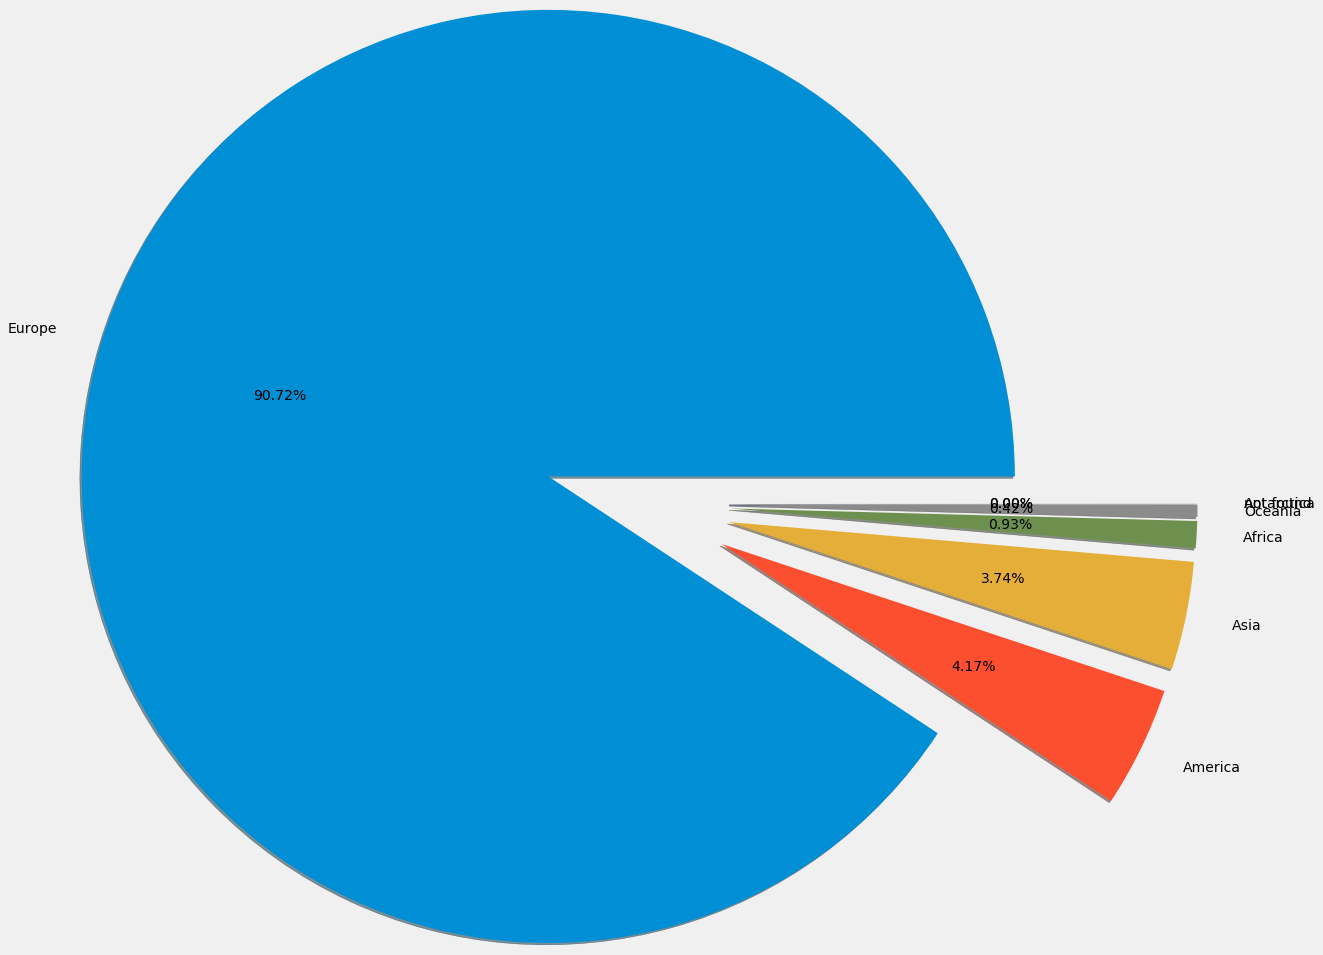

In [15]:
# visualization of continent-wise visitor distribution 
fig, ax = plt.subplots()
plt.axis('equal')
ax.pie(bookings.continent.value_counts(), labels=bookings.continent.value_counts().index, radius=5, autopct='%.2f%%', 
       shadow=True, explode=[1,1,1,1,1,1,1])
plt.show()

In [16]:
# Bookings with babies and childres are taken as a single entity 'kids'
bookings['kids'] = bookings.children + bookings.babies
bookings['total_members'] = bookings.kids + bookings.adults

In [17]:
# Arrival date to datetime
bookings['arrival_date_year'] = bookings['arrival_date_year'].astype('str')
bookings['arrival_date_month'] = bookings['arrival_date_month'].astype('str')
bookings['arrival_date_day_of_month'] = bookings['arrival_date_day_of_month'].astype('str')
bookings['arrival_date'] = bookings['arrival_date_day_of_month'] + '-' + bookings['arrival_date_month'] + '-' + bookings['arrival_date_year']
bookings['arrival_date'] = pd.to_datetime(bookings['arrival_date'], errors='coerce')

In [18]:
# applying string methode to convert to categorical feature
bookings['is_canceled'] = bookings['is_canceled'].astype('str')
bookings['is_repeated_guest'] = bookings['is_repeated_guest'].astype('str')

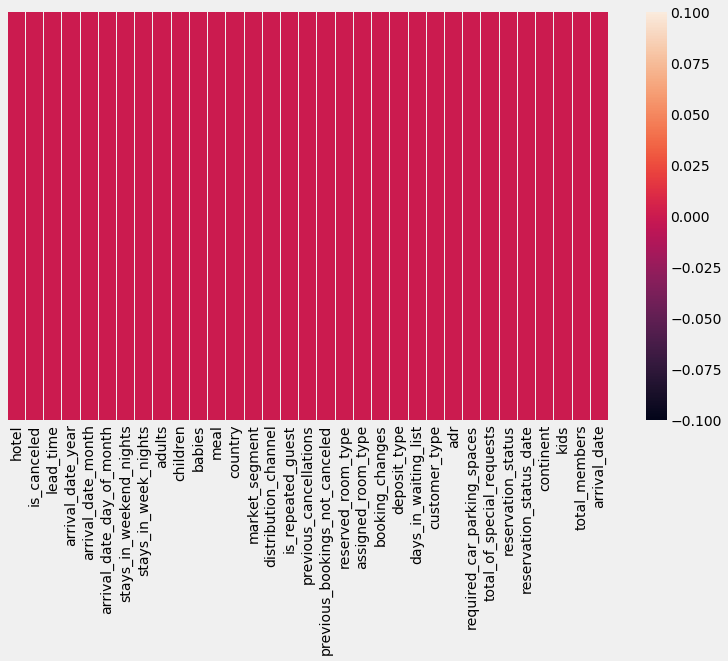

In [19]:
# Missing value visualization 
plt.figure(figsize=(12,7))
sns.heatmap(bookings.isnull(), yticklabels=False)
plt.show()

### New dataset confirmed bookings is created

In [20]:
confirmed_bookings = bookings[bookings.is_canceled=='0']

### Monthly arrivals

In [21]:
import datetime as dt
confirmed_bookings['arrival_month'] = bookings['arrival_date'].dt.month
confirmed_bookings.arrival_month.value_counts().sort_index()

1     4122
2     5372
3     6645
4     6565
5     7114
6     6404
7     7919
8     8638
9     6392
10    6914
11    4672
12    4409
Name: arrival_month, dtype: int64

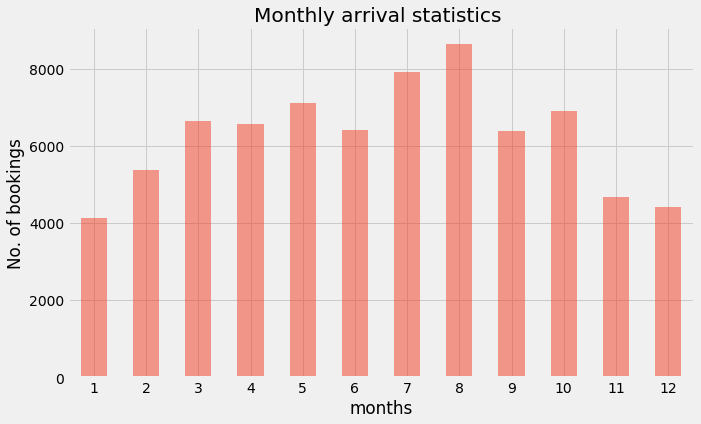

In [22]:
# Visualization of arrival on monthly basis for both types of hotels together
plt.figure(figsize=(12,5))
(confirmed_bookings.arrival_month.value_counts().sort_index()).plot(kind='bar',
                    figsize=(10,6), title = 'Monthly arrival statistics ', color='#f03b20', alpha=0.5)
plt.xlabel('months')
plt.ylabel('No. of bookings')
plt.xticks(rotation='horizontal')
plt.show()

### length of stay preference

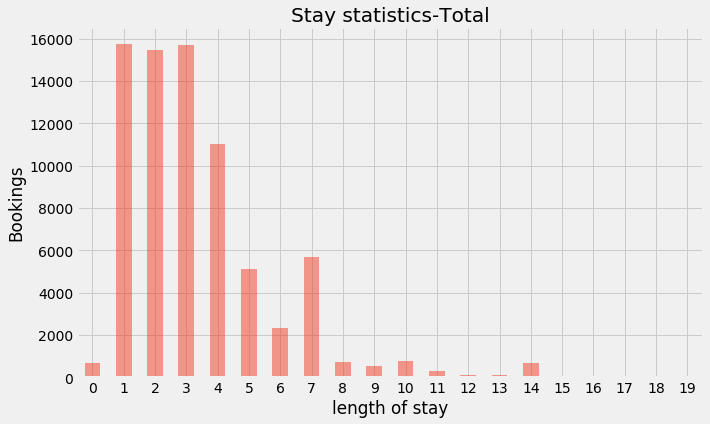

In [23]:
confirmed_bookings['total_span_of_stay'] = confirmed_bookings.stays_in_week_nights + confirmed_bookings.stays_in_weekend_nights
length_of_stay = confirmed_bookings.total_span_of_stay.value_counts().sort_index()
length_of_stay.head(20).plot(kind='bar', figsize=(10,6), title = 'length of stay', color='#f03b20', alpha=0.5)
plt.title('Stay statistics-Total')
plt.xlabel('length of stay')
plt.ylabel('Bookings')
plt.xticks(rotation='horizontal')
plt.show()

Just to have an idea of the preferred length of stay for city hotel and resort hotel seperately, we would divide the dataset into two

In [24]:
# Making  seperate dataframes for City hotels and Resort hotels
conf_book_city = confirmed_bookings[confirmed_bookings.hotel=='City Hotel']
conf_book_resort = confirmed_bookings[confirmed_bookings.hotel=='Resort Hotel']

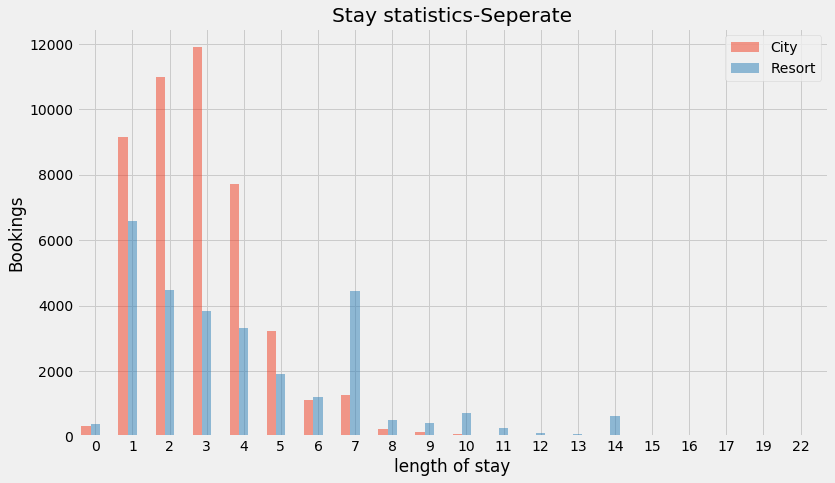

In [25]:
# Stay statistics based on type of hotel
city = conf_book_city.total_span_of_stay.value_counts().head(20).sort_index()
resort = conf_book_resort.total_span_of_stay.value_counts().head(20).sort_index()

position = list(range(len(city)))
width = 0.25

fig, ax = plt.subplots(figsize=(12,7))
plt.bar([p for p in position], city, width, alpha=0.5, color='#f03b20', label='City')
plt.bar([p+width for p in position], resort, width, alpha=0.5, color='#2c7fb8', label='Resort')

ax.set_xticks([p + width for p in position])
ax.set_xticklabels(city.index)
plt.xlim(min(position)-width, max(position)+width*4)
plt.title('Stay statistics-Seperate')
plt.xlabel('length of stay')
plt.ylabel('Bookings')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

### Weekday statistics of check-in's

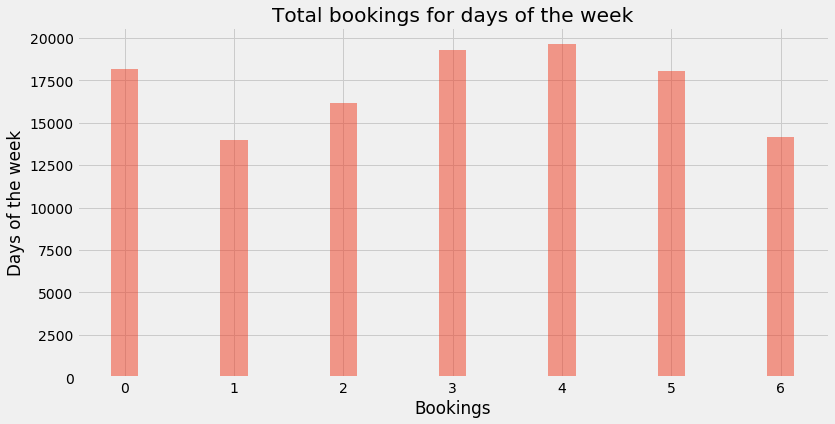

In [26]:
weekday = bookings.arrival_date.dt.weekday.value_counts().sort_index()

position = list(range(len(weekday))) 
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(position, weekday, width, alpha=0.5, color='#f03b20', label='Cancelled Bookings')

ax.set_xticks([p for p in position])
ax.set_xticklabels(city.index)
ax.set_title('Total bookings for days of the week')
ax.set_xlabel('Bookings')
ax.set_ylabel('Days of the week')
plt.show()

### Booking pattern over the years

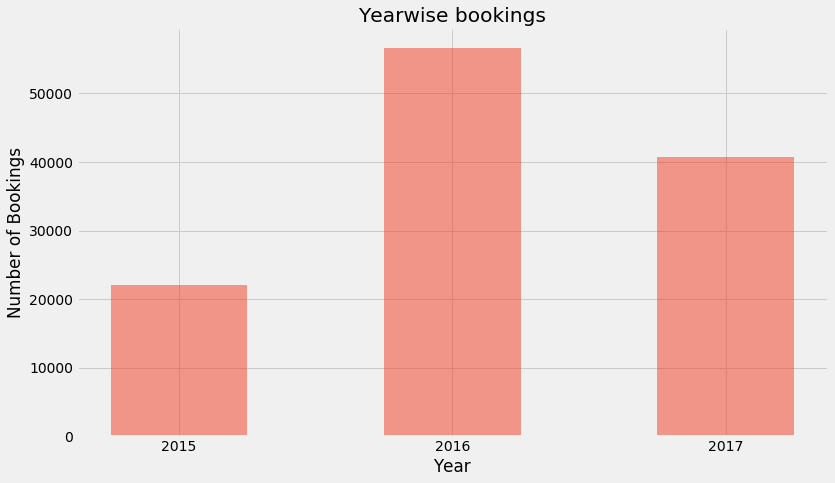

In [27]:
year = bookings.arrival_date.dt.year.value_counts().sort_index()
position = list(range(len(year))) 

fig, ax = plt.subplots(figsize=(12,7))
plt.bar(position, year, width=.50, alpha=0.5, color='#f03b20', label=year.index[0])

ax.set_xticks([p for p in position])
ax.set_xticklabels(year.index)
plt.title('Yearwise bookings')
plt.xlabel('Year')
plt.ylabel('Number of Bookings')
plt.show()

It is oberved that the year 2017 witnessed most number of check-in's

### Evaluating price per night per person

In [28]:
# Creating dataframe for price distribution
confirmed_bookings['total_legit_members'] = confirmed_bookings.adults + confirmed_bookings.children
confirmed_bookings_copy = confirmed_bookings.drop(index=confirmed_bookings.loc[confirmed_bookings.total_legit_members==0].index, axis=0)
confirmed_bookings_copy['price_night_person'] = confirmed_bookings_copy.adr/confirmed_bookings_copy.total_legit_members
prices = confirmed_bookings_copy[['hotel', 'reserved_room_type', 'price_night_person']].sort_values('reserved_room_type')
prices.head()

,hotel,reserved_room_type,price_night_person
119389,City Hotel,A,75.60
102432,City Hotel,A,89.55
77019,City Hotel,A,53.00
77020,City Hotel,A,53.00
77021,City Hotel,A,50.40


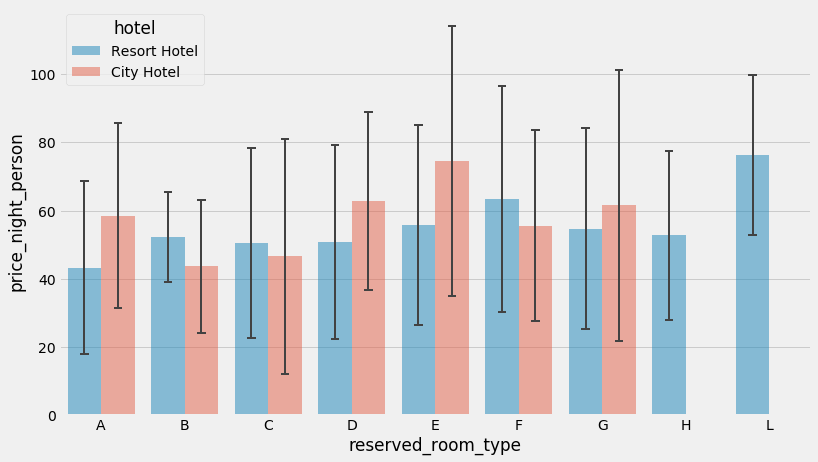

In [29]:
# Visualizing the price distribution
plt.figure(figsize=(12,7))
sns.barplot(x=confirmed_bookings_copy.reserved_room_type.sort_values(), y='price_night_person', hue='hotel', 
            data=confirmed_bookings_copy, alpha=0.5, ci='sd', errwidth=2, capsize=0.1)
plt.show()

### Room price variation over months

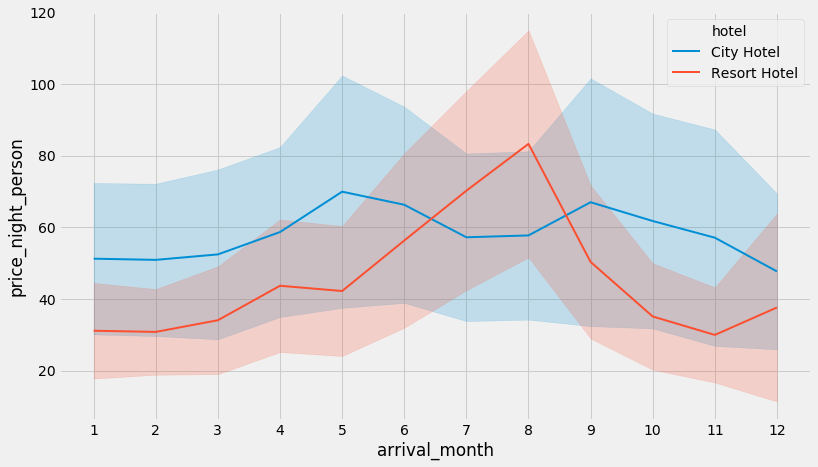

In [30]:
# Room price variation
price_variation = confirmed_bookings_copy[['hotel','arrival_month', 'price_night_person']].sort_values('arrival_month')
position = price_variation.arrival_month.value_counts().sort_index().index
fig, ax = plt.subplots(figsize=(12,7))
ax = sns.lineplot(x='arrival_month', y='price_night_person', hue='hotel', data=price_variation, ci='sd')
ax.set_xticks([p for p in position])
ax.set_xticklabels(position)
plt.show()

### Treatment of Numerical variables

In [31]:
numerical = [var for var in bookings.columns if bookings[var].dtypes!='object']
numerical

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'kids',
 'total_members',
 'arrival_date']

In [32]:
# after removing irrelevent numerical variables
numerical = ['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'kids']

In [33]:
# Finding the outliers
for j in numerical:
    IQR = bookings[j].quantile(0.75) - bookings[j].quantile(0.25)
    Lower_fence = bookings[j].quantile(0.25) - (IQR * 3)
    Upper_fence = bookings[j].quantile(0.75) + (IQR * 3)
    print(j + ' outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

lead_time outliers are values < -408.0 or > 586.0
stays_in_weekend_nights outliers are values < -6.0 or > 8.0
stays_in_week_nights outliers are values < -5.0 or > 9.0
adults outliers are values < 2.0 or > 2.0
previous_cancellations outliers are values < 0.0 or > 0.0
previous_bookings_not_canceled outliers are values < 0.0 or > 0.0
booking_changes outliers are values < 0.0 or > 0.0
days_in_waiting_list outliers are values < 0.0 or > 0.0
adr outliers are values < -100.83999999999999 or > 296.13
required_car_parking_spaces outliers are values < 0.0 or > 0.0
total_of_special_requests outliers are values < -3.0 or > 4.0
kids outliers are values < 0.0 or > 0.0


In [34]:
for k in numerical:
    print("the min and max values of " + k + " are {} and {}".format(bookings[k].min(), bookings[k].max()))

the min and max values of lead_time are 0 and 737
the min and max values of stays_in_weekend_nights are 0 and 19
the min and max values of stays_in_week_nights are 0 and 50
the min and max values of adults are 0 and 55
the min and max values of previous_cancellations are 0 and 26
the min and max values of previous_bookings_not_canceled are 0 and 72
the min and max values of booking_changes are 0 and 21
the min and max values of days_in_waiting_list are 0 and 391
the min and max values of adr are -6.38 and 5400.0
the min and max values of required_car_parking_spaces are 0 and 8
the min and max values of total_of_special_requests are 0 and 5
the min and max values of kids are 0.0 and 10.0


* ### Outliers are : 
* #### lead_time > 586.0
* #### stays_in_weekend_nights > 8
* #### stays_in_week_nights > 9
* #### adults > 2
* #### is_repeated_guest > 0
* #### previous_cancellations > 0
* #### previous_bookings_not_canceled > 0
* #### booking_changes > 0
* #### days_in_waiting_list > 0
* #### adr > 296.13
* #### required_car_parking_spaces > 0
* #### total_of_special_requests > 4
* #### kids > 0
* #### total_members > 2

In [35]:
def max_value(bookings, variable, top):
    return np.where(bookings[variable]>top, top, bookings[variable])
bookings['lead_time'] = max_value(bookings,'lead_time',586)
bookings['stays_in_weekend_nights'] = max_value(bookings,'stays_in_weekend_nights',8)
bookings['stays_in_week_nights'] = max_value(bookings,'stays_in_week_nights',9)
bookings['adults'] = max_value(bookings,'adults',2)
bookings['previous_cancellations'] = max_value(bookings,'previous_cancellations',0)
bookings['previous_bookings_not_canceled'] = max_value(bookings,'previous_bookings_not_canceled',0)
bookings['booking_changes'] = max_value(bookings,'booking_changes',0)
bookings['days_in_waiting_list'] = max_value(bookings,'days_in_waiting_list',0)
bookings['adr'] = max_value(bookings,'adr',296.13)
bookings['required_car_parking_spaces'] = max_value(bookings,'required_car_parking_spaces',0)
bookings['total_of_special_requests'] = max_value(bookings,'total_of_special_requests',4)
bookings['kids'] = max_value(bookings,'kids',0)   

### Treatment of Categorical Variables

In [36]:
categorical = [var for var in bookings.columns if bookings[var].dtypes=='object']
categorical

['hotel',
 'is_canceled',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date',
 'continent']

In [37]:
# after removing the irrelevent variables
categorical = ['is_canceled',
 'hotel',
 'meal',
 'continent',
 'is_repeated_guest',
 'market_segment',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status']

In [38]:
for i in categorical:
    bookings = pd.concat([bookings, pd.get_dummies(bookings[i], drop_first=True)], axis=1)

### Features, Labels and train_test_split

In [39]:
X = bookings.drop(['is_canceled', 'hotel', 'meal', 'is_repeated_guest', 'market_segment', 'reserved_room_type',
                   'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status','arrival_date_month', 'country',
                  'distribution_channel','reservation_status_date','arrival_date','continent'], axis=1)
y = bookings.is_canceled

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=0)

### Scaling using StandarsScaler

In [41]:
#Scaling
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

###  Classification using Logistic Regression

In [42]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Predictions

In [43]:
y_pred = logreg.predict(X_test)

In [44]:
confusion_matrix(y_test, y_pred)

array([[14934,     0],
       [    0,  8944]])

### Classification metrics

In [45]:
print("Accuracy score  : ", accuracy_score(y_test, y_pred))
print("Precision : ", precision_score(y_test, y_pred, pos_label='0'))
print("Recall score : ", recall_score(y_test, y_pred, pos_label='0'))

Accuracy score  :  1.0
Precision :  1.0
Recall score :  1.0


### This was a humble effort of a newbie!
### Kindly upvote if you like it!
### Suggestions and criticism are welcomed!